In [1]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from PIL import Image
import cv2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image, ImageEnhance



folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))

### Traning

In [2]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 10

STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

In [3]:
def network_1():
    # Input layer for grayscale images
    inputs = layers.Input(shape=(128, 128, 1), name="image_input")
    
    # Convert grayscale to 3 channels (required by ResNet50)
    #x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)

    # cách khác thành nhân 3 grayscale
    x = layers.Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    
    # Use ResNet50 with pre-trained weights
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=x)
    
    # Extract features
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    
    # Add Dense layer with 30 units
    outputs = layers.Dense(30, activation="relu", name="latent_space")(x)
    
    return tf.keras.Model(inputs, outputs, name="ResNetImageNetwork")

def network_2():
    inputs = layers.Input(shape=(8,), name="npy_input")
    outputs = tf.keras.layers.Dense(10, activation="relu")(inputs)  # Joint embedding
    return tf.keras.Model(inputs, outputs, name="JointStateNetwork")

def combined_model():
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")
    npy_input = layers.Input(shape=(8,), name="npy_input")
    
    image_output = network_1()(image_input)
    npy_output = network_2()(npy_input)
    
    combined = layers.Concatenate()([image_output, npy_output])
    latent_space = layers.Dense(20, activation="relu", name="latent_space")(combined)
    
    return tf.keras.Model(inputs=[image_input, npy_input], outputs=latent_space, name="CombinedModel")

def create_decoder():
    latent_input = layers.Input(shape=(20,), name="latent_input")
    
    # Expand latent space to ... features
    expanded_features = layers.Dense(110, activation="relu")(latent_input)
    
    # Slice features for image and joint decoders
    image_features = layers.Lambda(lambda x: x[:, :100], name="image_features")(expanded_features)
    joint_features = layers.Lambda(lambda x: x[:, 100:], name="joint_features")(expanded_features)

    # Decode to image (Symmetric to network_1)
    latent_image = layers.Dense(100, name="latent_image")(image_features)
    
    # Tăng chiều từ embedding (30) lên kích thước phù hợp để reshape
    x_img = layers.Dense(8 * 8 * 64, activation="relu")(latent_image)  # Kích thước trung gian: 8x8x64
    x_img = layers.Reshape((8, 8, 64))(x_img)  # Reshape thành 8x8x64
    # Lần lượt dùng Conv2DTranspose và UpSampling2D để tăng dần kích thước
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (16, 16, 64)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (32, 32, 128)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (64, 64, 128)
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (128, 128, 64)
    # Tầng cuối cùng đưa về kích thước (128, 128, 1)
    image_output = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same", name="reconstructed_image")(x_img)
    

    # Decode to joints (Symmetric to network_2)
    x_npy = layers.Dense(10, activation="relu")(joint_features)
    joint_output = layers.Dense(8, activation="linear", name="reconstructed_joint")(x_npy)
    
    return tf.keras.Model(inputs=latent_input, outputs=[image_output, joint_output], name="Decoder")


def downstream_task(pretrained_model_path="combine.weights.h5", freeze_up_to=None):
    # Load the pretrained model
    pretrained_model = combined_model()
    pretrained_model.load_weights(pretrained_model_path)

    # Freeze các lớp trong pretrained model (nếu cần)
    if freeze_up_to is not None:
        for layer in pretrained_model.layers[:-freeze_up_to]:
            layer.trainable = False

    # Input layers giống như mô hình đã pretrained
    image_input = pretrained_model.input[0]  # Input for images
    npy_input = pretrained_model.input[1]  # Input for joint state

    # Sử dụng output của pretrained model
    latent_space = pretrained_model.output

    # Thêm decoder
    decoder = create_decoder()
    image_output, joint_output = decoder(latent_space)

    # Tạo model mới
    downstream_model = tf.keras.Model(
        inputs=[image_input, npy_input],
        outputs=[image_output, joint_output],
        name="DownstreamModelWithDecoder"
    )
    return downstream_model



In [4]:
model = combined_model()
model.summary()

Model: "CombinedModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ npy_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNetImageNetwork  │ (None, 30)        │ 23,649,182 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ JointStateNetwork   │ (None, 10)        │         90 │ npy_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ ResNetImageNetwo… │
│ (Concatenate)       │                   │            │ JointStateNetwor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 20)        │        820 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,650,092 (90.22 MB)

 Trainable params: 23,596,972 (90.02 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
scaler = StandardScaler()

i1 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[:500]]
i2 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[500:]]

n1 = scaler.fit_transform(npy_file[:500])  # Joint data for training
n2 = scaler.fit_transform(npy_file[500:])  # Joint data for validation

full_images = i1.copy()
full_joints = n1.copy()

# image with joint == [-2]
random.seed(42)
missing_joints_indices = random.sample(range(500), 250)
images_missing_joints = [full_images[idx] for idx in missing_joints_indices]
joints_missing = [np.full((8,), -2) for _ in range(250)]

# joint with image == [-2]
remaining_indices = list(set(range(500)) - set(missing_joints_indices))
missing_images_indices = random.sample(remaining_indices, 250)
joints_missing_images = [full_joints[idx] for idx in missing_images_indices]
images_missing = [np.full((128, 128, 1), -2) for _ in range(250)]

# Full data
train_images_full = full_images
train_joints_full = full_joints

# Partial data
train_images_partial = np.concatenate([images_missing_joints, images_missing], axis=0)
train_joints_partial = np.concatenate([joints_missing, joints_missing_images], axis=0)

# Combine
train_images = np.concatenate([train_images_full, train_images_partial], axis=0)
train_joints = np.concatenate([train_joints_full, train_joints_partial], axis=0)

# dataset
train_inputs = tf.data.Dataset.from_tensor_slices((train_images, train_joints))
train_outputs = tf.data.Dataset.from_tensor_slices((train_images, train_joints))
train_ds = tf.data.Dataset.zip((train_inputs, train_outputs))\
            .batch(BATCH_SIZE)\
            .prefetch(tf.data.AUTOTUNE)

# Tạo tập validation (giữ nguyên)
val_inputs = tf.data.Dataset.from_tensor_slices((i2, n2))
val_outputs = tf.data.Dataset.from_tensor_slices((i2, n2))
val_ds = tf.data.Dataset.zip((val_inputs, val_outputs))\
        .batch(BATCH_SIZE)\
        .prefetch(tf.data.AUTOTUNE)


In [13]:
# Tạo model với decoder
decoder_model = downstream_task(
    pretrained_model_path="combine.weights.h5", 
    freeze_up_to = 30  # Freeze các lớp đầu tiên, fine-tune n lớp cuối
)

# Compile the model
# decoder_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss={
#         "reconstructed_image": tf.keras.losses.MeanSquaredError(),  # Loss cho image reconstruction
#         "reconstructed_joint": tf.keras.losses.MeanSquaredError(),  # Loss cho joint reconstruction
#     },
#     loss_weights={
#         "reconstructed_image": 3.0,  # Trọng số cho loss image
#         "reconstructed_joint": 1.0,  # Trọng số cho loss joint
#     },
#     metrics={
#         "reconstructed_image": [tf.keras.metrics.MeanSquaredError(name="mse_image")],
#         "reconstructed_joint": [tf.keras.metrics.MeanSquaredError(name="mse_joint")],
#     }
# )

decoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=["mse", "mse"],  # Loss cho ảnh và joints
    loss_weights=[3.0, 1.0],  # image:joints ratio
    metrics=["mse",'mse']
)


In [14]:
#Train
history = decoder_model.fit(
    train_ds,  # Dataset both (image_input, npy_input) and (image_output, joint_output)
    validation_data=val_ds,
    epochs=10,
    batch_size=32,
    verbose=1
)
#decoder_model.load_weights("reconstruct.weights.h5")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - Decoder_loss: 1.2909 - Decoder_mse: 0.2421 - Decoder_mse_1: 1.2901 - loss: 2.0165 - val_Decoder_loss: 7.9335 - val_Decoder_mse: 0.0917 - val_Decoder_mse_1: 7.8571 - val_loss: 8.1323
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - Decoder_loss: 1.2944 - Decoder_mse: 0.2852 - Decoder_mse_1: 1.2936 - loss: 2.1491 - val_Decoder_loss: 34.8505 - val_Decoder_mse: 0.0917 - val_Decoder_mse_1: 34.6976 - val_loss: 34.9727
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - Decoder_loss: 1.2677 - Decoder_mse: 0.2852 - Decoder_mse_1: 1.2668 - loss: 2.1223 - val_Decoder_loss: 29110.2285 - val_Decoder_mse: 0.0917 - val_Decoder_mse_1: 29100.2969 - val_loss: 29100.5762
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - Decoder_loss: 1.2284 - Decoder_mse: 0.2852 - Decoder_mse_1: 1.2273 - loss: 2.0829 - val_Decoder_loss: 1549.7211 - val_Decoder_mse: 0.0917 - val_Decoder_mse_1: 1552.3617 - val_loss: 1552.6370
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


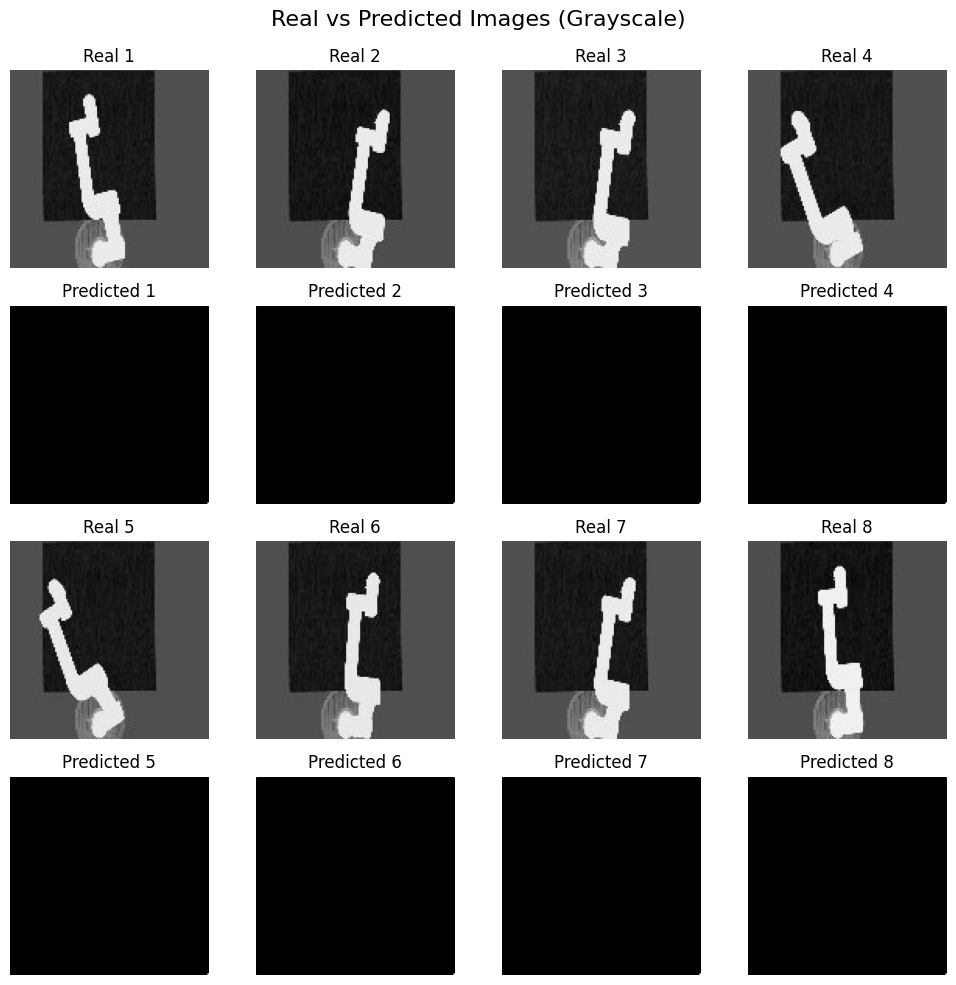

In [15]:
# Visualize reconstructed images
for data, labels in val_ds.take(1):
    img_input = data[0]
    joint_input = data[1]
    true_img = labels[0]
    true_joint = labels[1]

    # Predict reconstructions
    predicted_img, predicted_joint = decoder_model.predict({"image_input": img_input, "npy_input": joint_input})

# # Lấy một batch từ validation dataset
# for batch in val_ds.take(1):
#     (input_images, input_joints), (real_images, real_joints) = batch

# Convert tensor sang numpy array nếu cần
real_images = true_img.numpy()  # Ground truth (thực tế)
predicted_images = predicted_img  # Dự đoán (đã có sẵn dưới dạng numpy array)



def plot_real_vs_predicted(real_images, predicted_images, n=8):
    # # Lấy một batch từ validation dataset
    # for batch in val_ds.take(1):
    #     (input_images, input_joints), (real_images, real_joints) = batch

    # # Convert tensor sang numpy array nếu cần
    # real_images = real_images.numpy()
    # predicted_images = np.array(predicted_images)  # Convert predicted_images nếu cần
    
    # Đảm bảo n không vượt quá số lượng ảnh trong batch
    n = min(n, real_images.shape[0], predicted_images.shape[0])
    
    cols = min(4, n)  # Giới hạn số cột để giữ ảnh lớn hơn
    rows = (n + cols - 1) // cols  # Số hàng được tính tự động để vừa với n ảnh

    # Tạo một figure để hiển thị ảnh
    fig, axes = plt.subplots(2 * rows, cols, figsize=(10, 10))  # Gấp đôi số hàng để hiển thị cả ảnh thực tế và dự đoán
    fig.suptitle("Real vs Predicted Images (Grayscale)", fontsize=16)

    # Plot ảnh thực tế và dự đoán
    for i in range(n):
        # Plot ảnh thực tế
        ax_real = axes[2 * (i // cols), i % cols]  # Dòng chẵn: ảnh thực tế
        ax_real.imshow(real_images[i, :, :, 0], cmap='gray')
        ax_real.axis("off")
        ax_real.set_title(f"Real {i+1}")

        # Plot ảnh dự đoán
        ax_pred = axes[2 * (i // cols) + 1, i % cols]  # Dòng lẻ: ảnh dự đoán
        ax_pred.imshow(predicted_images[i, :, :, 0], cmap='gray')
        ax_pred.axis("off")
        ax_pred.set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Điều chỉnh tiêu đề không bị chèn lên các ảnh
    plt.show()

# Sử dụng hàm với n ảnh tùy chỉnh
plot_real_vs_predicted(real_images, predicted_images, n=8)



In [9]:
#decoder_model.save_weights("reconstruct_partial.weights.h5")

In [10]:
decoder_model.summary()

Model: "DownstreamModelWithDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ npy_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNetImageNetwork  │ (None, 30)        │ 23,649,182 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ JointStateNetwork   │ (None, 10)        │         90 │ npy_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ ResNetImageNetwo… │
│ (Concatenate)       │                   │            │ JointStateNetwor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 20)        │        820 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ [(None, 128, 128, │    759,041 │ latent_space[0][… │
│ (Functional)        │ 1), (None, 8)]    │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,121,161 (278.94 MB)

 Trainable params: 24,356,013 (92.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,712,028 (185.82 MB)